<a href="https://colab.research.google.com/github/undertow515/123123/blob/main/gmm_ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32220\867734649.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample("M").sum()


<Axes: ylabel='Frequency'>

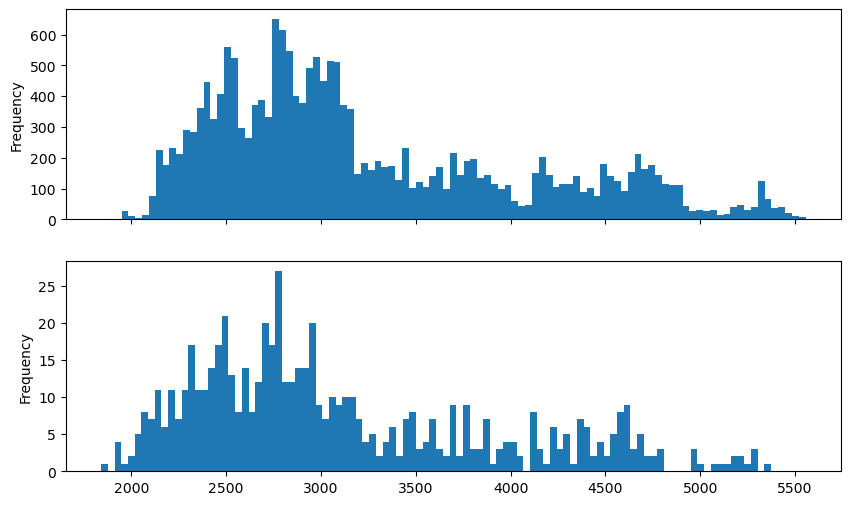

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
path = "https://github.com/undertow515/123123/blob/main/dg/kma/kma_100_full.csv?raw=true"
df = pd.read_csv(path)
df
df = df[["kst", "precip_mm"]]
df["kst"] = pd.to_datetime(df["kst"])
df.set_index("kst", inplace=True)
df.fillna(0, inplace=True)
df_monthly = df.resample("M").sum()

window_d = 365 + 365
df_daily_rolled = df.rolling(window=window_d).sum()
df_monthly_rolled = df_monthly.rolling(window=window_d // 31).sum()


fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

df_daily_rolled["precip_mm"].plot(kind="hist", bins=100, ax=ax[0])
df_monthly_rolled["precip_mm"].plot(kind="hist", bins=100, ax=ax[1])

# are this histograms multi-modal or not?
# what do you think?


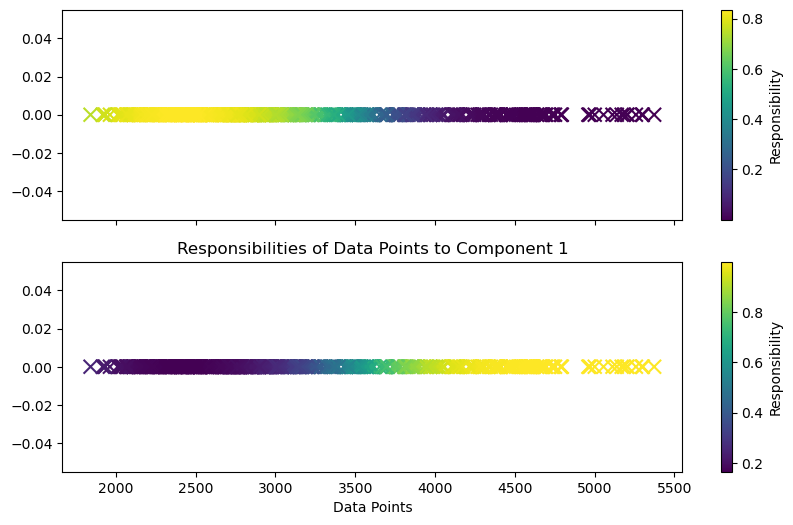

In [ ]:
# let's assume that the data is multi-modal
# we will use GMM to fit the data (From scratch)

# k = 2
# 1. initialize the parameters
# 2. E-step
# 3. M-step
# 4. repeat 2 and 3 until convergence

# lets initialize.... component1 (mean=2600, std=np.sqrt(500), weight=0.6)
# component2 (mean=3500, std=np.sqrt(1200), weight=0.4)
# doing this maually (it's just example)

import numpy as np




params = np.full((2, 3), 0.0)
params[0] = [2600, 500, 0.6]
params[1] = [3500, 1200, 0.4]
data = df_monthly_rolled["precip_mm"].dropna().values

def gaussian(x, mean, std):
    coeff = 1 / (std * np.sqrt(2 * np.pi))
    exponent = np.exp(-0.5 * ((x - mean) / std) ** 2)
    return coeff * exponent

def e_step(data, params, n_components=2):
    # get responsibilities of each component for each data point
    responsibilities = np.zeros((data.shape[0], 2)) # initialize (n_samples, n_components)
    for k in range(n_components):
        mean, std, weight = params[k]
        responsibilities[:, k] = weight * gaussian(data, mean, std)
    responsibilities_sum = responsibilities.sum(axis=1)[:, np.newaxis]
    responsibilities /= responsibilities_sum
    return responsibilities

# yes, lets do e_step once and see the results

responsibilities = e_step(data, params)
responsibilities

def plot_responsibilities(data, responsibilities):
    fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    ax[0].scatter(data, np.zeros_like(data), c=responsibilities[:, 0], cmap="viridis", marker="x", s=100)
    ax[1].scatter(data, np.zeros_like(data), c=responsibilities[:, 1], cmap="viridis", marker="x", s=100)
    plt.xlabel("Data Points")
    plt.title("Responsibilities of Data Points to Component 1")
    plt.colorbar(ax[0].collections[0], ax=ax[0], label="Responsibility")
    plt.colorbar(ax[1].collections[0], ax=ax[1], label="Responsibility")
    plt.show()

plot_responsibilities(data, responsibilities)




In [ ]:
# okay, now lets do M-step

def m_step(data, responsibilities, n_components=2):
    n_samples = data.shape[0]
    updated_params = np.full((n_components, 3), 0.0) # becareful, this will reset the params
    for k in range(n_components):
        resp = responsibilities[:, k]
        N_k = resp.sum() # effective number of points assigned to component k
        mean = (resp * data).sum() / N_k
        variance = (resp * (data - mean) ** 2).sum() / N_k
        std = np.sqrt(variance)
        weight = N_k / n_samples
        updated_params[k] = [mean, std, weight]
    return updated_params

# lets do m_step once and see the results
updated_params = m_step(data, responsibilities)
params, updated_params

(array([[2.6e+03, 5.0e+02, 6.0e-01],
        [3.5e+03, 1.2e+03, 4.0e-01]]),
 array([[2.69620030e+03, 4.05140572e+02, 5.88931636e-01],
        [3.68993358e+03, 8.53506864e+02, 4.11068364e-01]]))

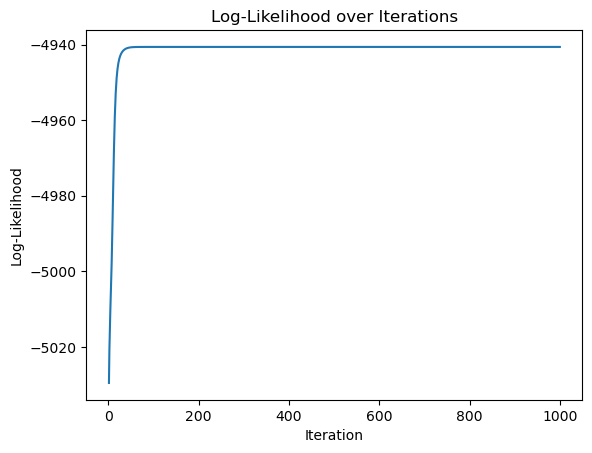

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32220\3324531626.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


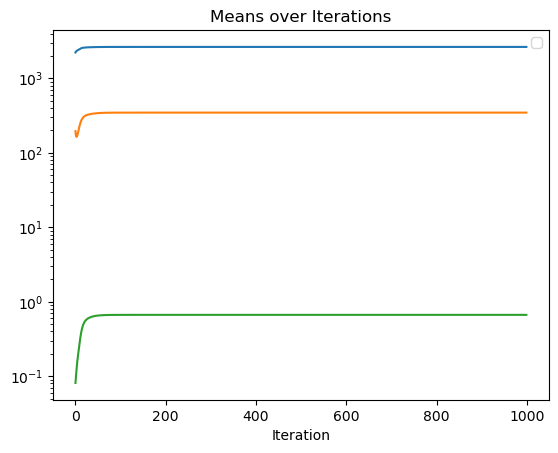

In [ ]:
# see the params are changing
# now lets do the whole process iteratively
# and trace the log-likelihood of our model
log_likelihoods = []
n_iterations = 1000
params_trace = np.zeros((n_iterations, 2, 3))

# we again, initialize the params
params = np.full((2, 3), 0.0)
params[0] = [1000, 500, 0.6]
params[1] = [4000, 1200, 0.4]

for i in range(n_iterations):
    responsibilities = e_step(data, params)
    # plot_responsibilities(data, responsibilities)
    params = m_step(data, responsibilities)
    # compute log-likelihood
    likelihood = np.zeros((data.shape[0], 2))
    for k in range(2):
        mean, std, weight = params[k]
        likelihood[:, k] = weight * gaussian(data, mean, std)
    params_trace[i] = params
    log_likelihood = np.log(likelihood.sum(axis=1)).sum()
    log_likelihoods.append(log_likelihood)
    # print(f"Iteration {i+1}, Log-Likelihood: {log_likelihood}, Params: {params}")

plt.plot(range(1, n_iterations + 1), log_likelihoods)
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.title("Log-Likelihood over Iterations")
plt.show()

plt.plot(params_trace[:, 0, :])
# plt.plot(params_trace[:, 1, :])
plt.yscale("log")
plt.xlabel("Iteration")
plt.title("Means over Iterations")
plt.legend()
plt.show()

In [ ]:
# gamma fitting and loglikelihood?
from scipy.stats import gamma
a, loc, scale = gamma.fit(data)
a, loc, scale
x = np.linspace(0, 8000, 1000)

gamma_loglik = np.log(gamma.pdf(data, a, loc=loc, scale=scale)).sum()
print("Gamma Log-Likelihood:", gamma_loglik)

Gamma Log-Likelihood: -4962.860641519032


In [ ]:
# which log-likelihood is better?
# GMM log-likelihood
gmm_loglik = log_likelihoods[-1]
print("GMM Log-Likelihood:", gmm_loglik)
# Gamma log-likelihood
print("Gamma Log-Likelihood:", gamma_loglik)

GMM Log-Likelihood: -4940.604840809312
Gamma Log-Likelihood: -4962.860641519032


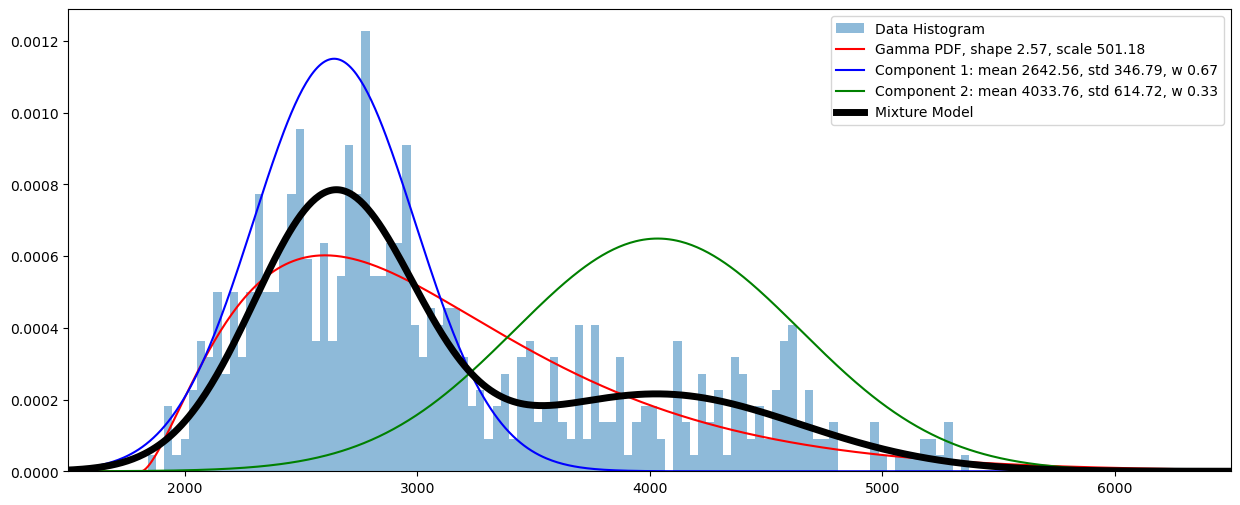

In [ ]:
# okay... now see the pdf of both distributions
plt.figure(figsize=(15, 6))
plt.hist(data, bins=100, density=True, alpha=0.5, label="Data Histogram")

plt.plot(x, gamma.pdf(x, a, loc=loc, scale=scale), label="Gamma PDF, shape {:.2f}, scale {:.2f}".format(a, scale), color="red")
plt.plot(x, gaussian(x, params[0, 0], params[0, 1]), color="blue",label="Component 1: mean {:.2f}, std {:.2f}, w {:.2f}".format(params[0,0], params[0,1], params[0,2]), )
plt.plot(x, gaussian(x, params[1, 0], params[1, 1]), color="green", label="Component 2: mean {:.2f}, std {:.2f}, w {:.2f}".format(params[1,0], params[1,1], params[1,2]), )
w1 = params[0, 2]
w2 = params[1, 2]
plt.plot(x, w1 * gaussian(x, params[0, 0], params[0, 1]) + w2 * gaussian(x, params[1, 0], params[1, 1]), color="black", label="Mixture Model", lw=5)
plt.xlim(1500, 6500)
plt.legend()
plt.show()


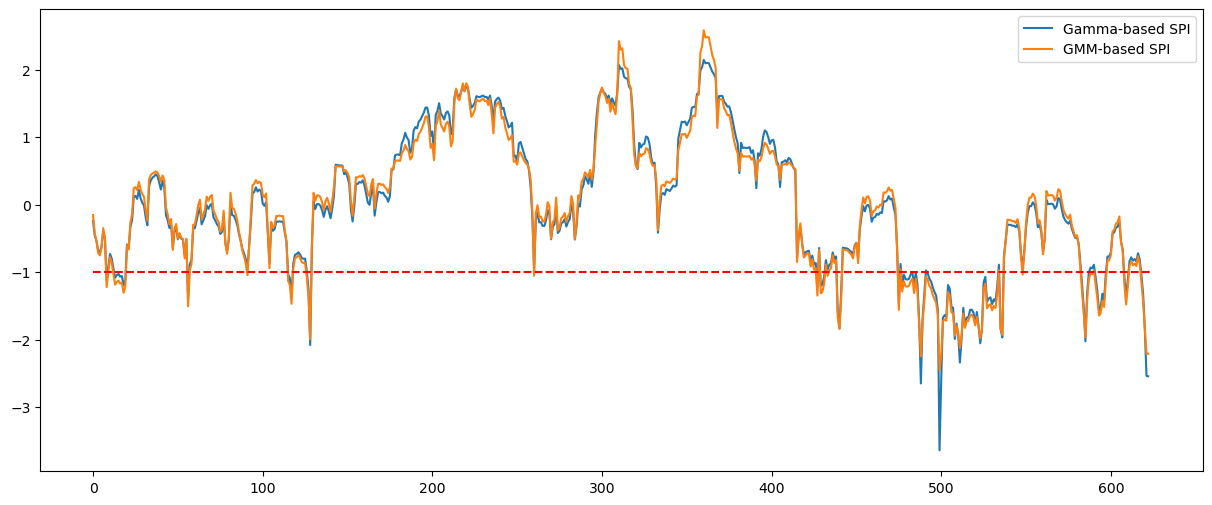

(KstestResult(statistic=0.028141734315722533, pvalue=0.6962658056954694, statistic_location=-0.6608249862571204, statistic_sign=1),
 KstestResult(statistic=0.05919654120530149, pvalue=0.024368321988417763, statistic_location=0.046772122086257, statistic_sign=1))

In [ ]:
from scipy.special import erf
from scipy import stats
def gmm_cdf(x, params):
    w1 = params[0, 2]
    w2 = params[1, 2]
    cdf1 = 0.5 * (1 + erf((x - params[0, 0]) / (params[0, 1] * np.sqrt(2))))
    cdf2 = 0.5 * (1 + erf((x - params[1, 0]) / (params[1, 1] * np.sqrt(2))))
    return w1 * cdf1 + w2 * cdf2

cdf = gmm_cdf(data, params)
spi = stats.norm.ppf(cdf)

cdf2 = stats.gamma.cdf(data, a, loc=loc, scale=scale)
spi2 = stats.norm.ppf(cdf2)



plt.figure(figsize=(15, 6))
plt.plot(spi2, label="Gamma-based SPI")
plt.plot(spi, label="GMM-based SPI")
plt.hlines(xmin = 0 , xmax = len(data), y = -1, colors="red", linestyles="dashed")
plt.legend()
plt.show()

# and lastly, normality test of spi values

from scipy.stats import shapiro, anderson, kstest, normaltest

# see the diffrences between two methods !

# in ks-test, null hypothesis is that the data is normal
# if p-value < 0.05, we reject the null hypothesis
# if p-value >= 0.05, we fail to reject the null hypothesis!!

kstest_test_gmm = kstest(spi, 'norm')
kstest_test_gamma = kstest(spi2, 'norm')
kstest_test_gmm, kstest_test_gamma







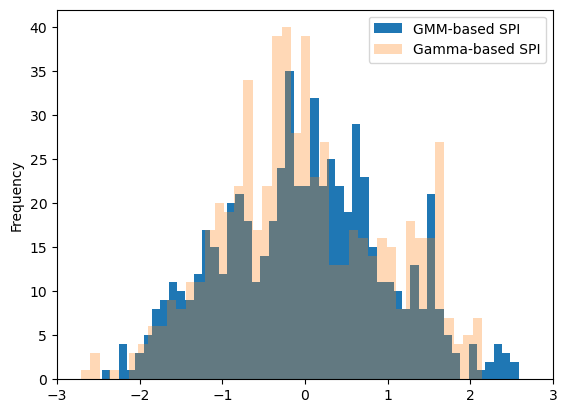

In [ ]:
plt.hist(spi, bins=50, alpha=1, label="GMM-based SPI")
plt.hist(spi2, bins=50, alpha=0.3, label="Gamma-based SPI")
plt.xlim(-3, 3)
plt.ylabel("Frequency")
plt.legend()
plt.show()